# Getting Started with the Apollo Passive Seismic Data Archive



Nunn, C., Nakamura, Y., Kedar, S., Panning, M.P., 2022, Planetary Science Journal. A New Archive of Apollo’s Lunar Seismic Data.  https://doi.org/10.3847/PSJ/ac87af

The data are archived with the following DOI: https://doi.org/10.7914/SN/XA_1969.

1) Connecting to IRIS and viewing a raw seismogram.

2) Plotting a seismogram with the instrument response removed

3) Viewing the instrument response for a peaked mid-period seismogram.

4) Viewing the timing divergence 

5) Correcting for the timing divergence 

The archive is public at IRIS and the Planetary Data System.

## Users should note the following points about the data: 
    
1) The sampling rate was variable. The data are sampled using a constant sampling interval. Therefore, the sample time and the data timestamp are not the same, and diverge throughout the day. CHECK THE TIMING TRACE (channel=ATT). Different stations had different variations. 

2) Because there were a lot of missing samples (3 missing samples every 32 samples for SHZ), we use -1 to store a missing sample to reduce file storage size. Replace the -1 values with a blank space or interpolate across the gap  (see below for some example code).

3) The transfer functions and gain in the metadata are nominal. Check CalibrationFiles on this site for times when the gain changed. 

4) There may be short periods marked as peaked mode (location code '00')  which should be flat mode (location code '01') and vice versa. 

5) The digitization was very coarse. Particularly at low signal-to-noise ratios, the data may be too coarsely digitized to be meaningful. 

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from future.builtins import *  # NOQA
from datetime import timedelta
from obspy.core import read
from obspy.core.utcdatetime import UTCDateTime
from obspy.core.inventory import read_inventory
import numpy as np
from obspy.clients.fdsn.client import Client
import pdart.auth as auth
from pdart.util import linear_interpolation, timing_correction
from pdart.extra_plots.plot_timing_divergence import plot_timing

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['font.size'] = 12
SECONDS_PER_DAY=3600.*24

In [2]:
def raw_seismogram():
    """View a raw seismogram.
    """
    user=auth.user
    auth_password=auth.auth_password
    
    if user == '' or auth_password == '':
        print('Set user and auth_password in auth.py')
        return
    
    starttime= UTCDateTime('1973-03-13T07:30:00.0')
    endtime = UTCDateTime('1973-03-13T09:30:00.0')
    network='XA'
    station='S14'
    channel='MH1'
    location='*'

    client = Client("IRIS",user=user,password=auth_password)
    print(client)
    
    stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)
    stream.plot(equal_scale=False,size=(1000,600),method='full')
    

FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.51), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


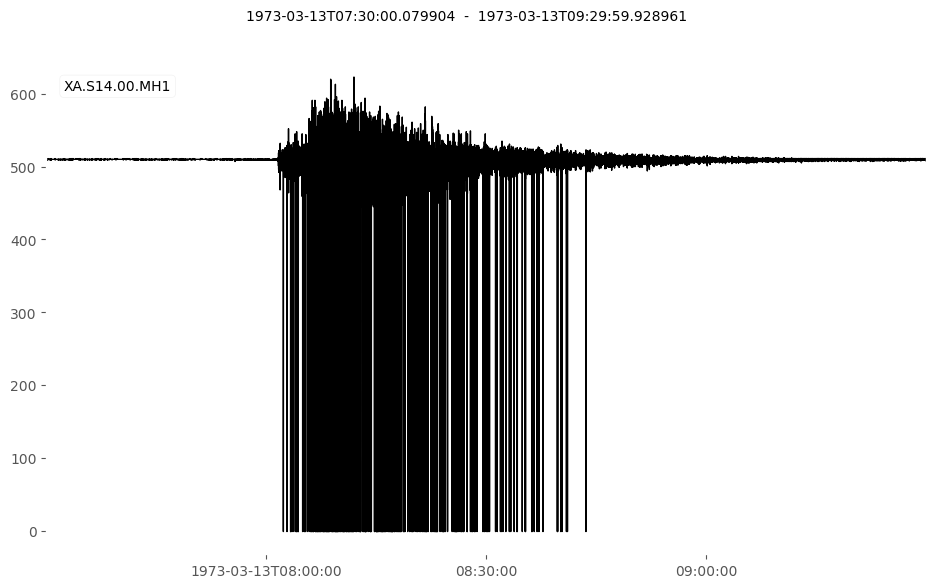

In [3]:
raw_seismogram()

Notice that the raw seismogram is :
    
1) In digital units
    
2) That the gaps in the trace are replaced by -1. This is for performance reasons, especially for the short-period channel SHZ. 
    
    

Now we we plot the seismogram with the -1 values replaced. 
If there is only one missing value, we ask for it to be interpolated. But if there are more than one missing value, we
we mark it as a gap on the trace. 

The missing data must be dealt with before removing the instrument response. 

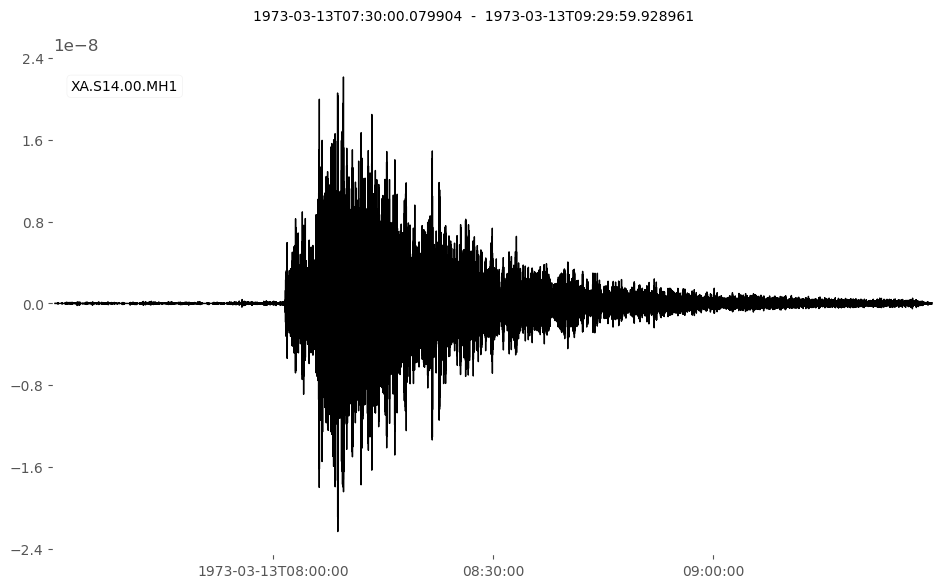

In [4]:
def view_Apollo(stream=None,starttime= UTCDateTime('1973-03-13T07:30:00.0'),endtime = UTCDateTime('1973-03-13T09:30:00.0'),
  network='XA',station='S14',channel='MH1',location='*',plot_seismogram=True,plot_response=False):
    """Snippet to read in raw seismogram and remove the instrument response for Apollo.
    
    client = Client("IRIS",user=user)

    # get the response file (wildcards allowed)
    inv = client.get_stations(starttime=starttime, endtime=endtime,
        network=network, sta=station, loc=location, channel=channel,
        level="response")

    if stream is None:
        stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)

    else:
        stream.trim(starttime=starttime,endtime=endtime)
        
    
    for tr in stream:
        # interpolate across the gaps of one sample 
        linear_interpolation(tr,interpolation_limit=1)
    stream.merge()
    
    for tr in stream:
        # optionally interpolate across any gap 
        # for removing the instrument response from a seimogram, 
        # it is useful to get a mask, then interpolate across the gaps, 
        # then mask the trace again. 
        if tr.stats.channel in ['MH1', 'MH2', 'MHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [0.1,0.3,0.9,1.1]
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

        elif tr.stats.channel in ['SHZ']:

            # add linear interpolation but keep the original mask
            original_mask = linear_interpolation(tr,interpolation_limit=None)
            # remove the instrument response
            pre_filt = [1,2,11,13] 
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP",
                       water_level=None, plot=plot_response)
            if plot_response:
                plt.show()
            
            # apply the mask back to the trace 
            tr.data = np.ma.masked_array(tr, mask=original_mask)

    if plot_seismogram:
        stream.plot(equal_scale=False,size=(1000,600),method='full')
    
view_Apollo()

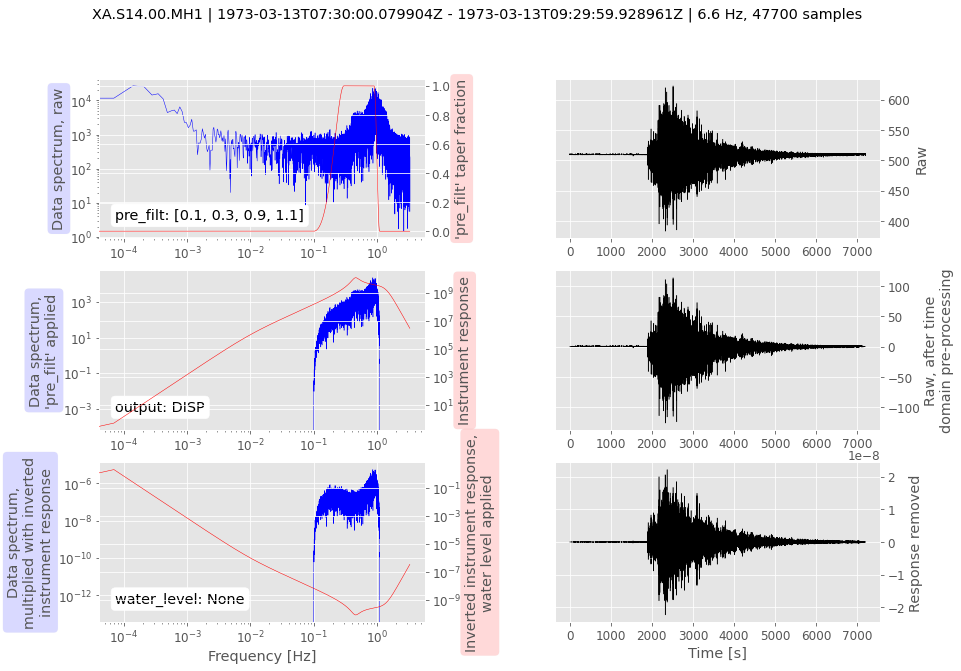

In [9]:
view_Apollo(plot_seismogram=False,plot_response=True)

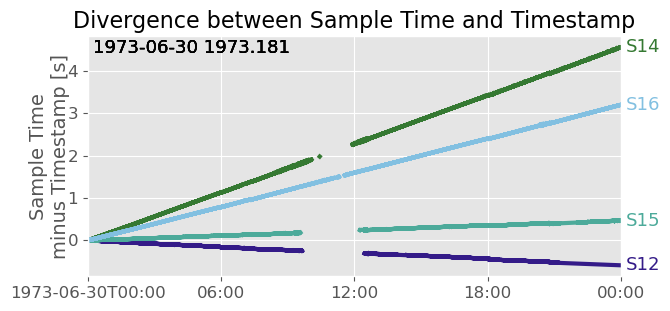

In [15]:
def view_timing_divergence(starttime= UTCDateTime('1973-06-30T00:00:00.00000Z'),endtime= UTCDateTime('1973-07-01T00:00:00.00000Z'), network='XA',
  station='*',channel='ATT',location='*'):
    
    user=auth.user
    auth_password=auth.auth_password

    if user == '' or auth_password == '':
        print('Set user and auth_password in auth.py')
        return

    client = Client("IRIS",user=user,password=auth_password)

    stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)

    plot_timing(stream=stream, start_time=starttime,end_time=endtime,save_fig=False)


view_timing_divergence()

In the next section, we will make a correction for the timing divergence. Taking the approximate onset time of the event, (1973-03-13T07:30:00.0), we will shift the timings slightly. This will be useful when comparing the onset times.  

In [10]:
def get_traces():
    """Get the traces
    """
    user=auth.user
    auth_password=auth.auth_password
    
    if user == '' or auth_password == '':
        print('Set user and auth_password in auth.py')
        return
    
    starttime= UTCDateTime('1973-03-13T00:00:00.0')
    endtime = UTCDateTime('1973-03-14T00:00:00.0')
    network='XA'
    station='*'
    channel='*'
    location='*'

    client = Client("IRIS",user=user,password=auth_password)
    print(client)
    
    stream = client.get_waveforms(network=network, station=station, channel=channel, location=location, starttime=starttime, endtime=endtime)
    return stream
    
    
stream_before = get_traces()
print(stream_before)

FDSN Webservice Client (base url: http://service.iris.edu)
Available Services: 'dataselect' (v1.1.9), 'event' (v1.1.13), 'station' (v1.1.51), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.
18 Trace(s) in Stream:
XA.S12..ATT   | 1973-03-13T00:00:00.359000Z - 1973-03-13T14:21:19.755226Z | 1.7 Hz, 85595 samples
XA.S12.00.MH1 | 1973-03-13T00:00:00.434000Z - 1973-03-13T14:21:20.283057Z | 6.6 Hz, 342380 samples
XA.S12.00.MH2 | 1973-03-13T00:00:00.453000Z - 1973-03-13T14:21:20.302057Z | 6.6 Hz, 342380 samples
XA.S12.00.MHZ | 1973-03-13T00:00:00.472000Z - 1973-03-13T14:21:20.321057Z | 6.6 Hz, 342380 samples
XA.S14..ATT   | 1973-03-13T00:00:00.458000Z - 1973-03-13T23:59:59.854226Z | 1.7 Hz, 143100 samples
XA.S14..SHZ   | 1973-03-13T00:00:00.002001Z - 1973-03-13T23:59:59.756718Z | 53.0 Hz, 4579188 samples
XA.S14.00.MH1 | 1973-03-1

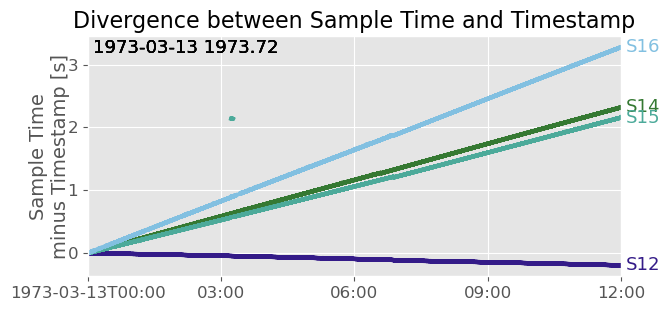

In [11]:
# plot the timing divergence before correction
plot_timing(stream=stream_before, start_time=UTCDateTime('1973-03-13T00:00:00.0'),end_time=UTCDateTime('1973-03-13T12:00:00.0'),save_fig=False)
    

In [12]:
stream_after = stream_before.copy()
correction_time=UTCDateTime('1973-03-13T08:02:00.0')
timing_correction(stream_after,correction_time=correction_time)

need to make corrections for each channel in the trace
Warming - merge may not be necessary
Warning - Interpolating the sample number for the timing correction.
Correction Time for Station  S15 -1.759491
Warning - Interpolating the sample number for the timing correction.
Correction Time for Station  S16 -2.715038
Warning - Interpolating the sample number for the timing correction.
Correction Time for Station  S12 0.09383
Warning - Interpolating the sample number for the timing correction.
Correction Time for Station  S14 -1.816491


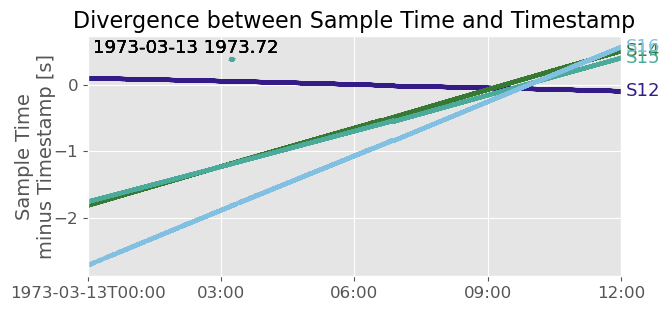

In [13]:
# timing divergence after correction
plot_timing(stream=stream_after, start_time=UTCDateTime('1973-03-13T00:00:00.0'),end_time=UTCDateTime('1973-03-13T12:00:00.0'),save_fig=False)

It can be seen from the previous image the extent of the timing divergence. It many situations it may be necessary to do more than just correct the start times, but instead to reinterpolate the data. 
The real onset time will also be affected by the divergence between the sampling time and the timestamp. 

In [14]:
print('End of Notebook')

End of Notebook
